<a href="https://colab.research.google.com/github/kd365/faafall22/blob/hill/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NTSB Cleaning Notebook

## Steps:
1. Import libraries and raw data
2. Initial column drops
3. Cleaning steps that wil apply to entire dataframe
4. Cleaning each column

**Cleaning Plan:**
Hunter:
- cols 0-22
Kathleen:
- col 23-45
Eric:
- col 46-68
Chi:
- col 69-85


### 1. Import libraries

In [8]:
from google.colab import files
import pandas as pd
import numpy as np


uploaded = files.upload()

Saving NTSB_for_cleaning_total.csv to NTSB_for_cleaning_total.csv


In [9]:
import re

In [10]:
# setting pandas display options
pd.set_option('display.max_rows', 150)

# reading in NTSB csv file
ntsb_raw = pd.read_csv("NTSB_for_cleaning_total.csv", encoding='latin-1', low_memory=False)
ntsb_raw = ntsb_raw.drop(['engines_ev_id', 'events_ev_id', 'Unnamed: 0'], axis=1)
# view the dataframe info
ntsb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104120 entries, 0 to 104119
Data columns (total 86 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   aircraft_ev_id         104120 non-null  object 
 1   far_part               104120 non-null  object 
 2   flight_plan_activated  45517 non-null   object 
 3   damage                 103326 non-null  object 
 4   acft_make              104108 non-null  object 
 5   acft_model             104096 non-null  object 
 6   cert_max_gr_wt         93685 non-null   float64
 7   num_eng                102746 non-null  float64
 8   type_last_insp         99030 non-null   object 
 9   date_last_insp         83764 non-null   object 
 10  afm_hrs_last_insp      58888 non-null   float64
 11  afm_hrs                84919 non-null   float64
 12  type_fly               100532 non-null  object 
 13  dprt_apt_id            85958 non-null   object 
 14  dprt_city              88866 non-nul

### 2. Initial Drop

In [11]:
# drop all records that do not have at least 50 columns worth of data in them
ntsb_raw = ntsb_raw.dropna(thresh=50)

In [7]:
# view data
ntsb_raw.head()

,aircraft_ev_id,far_part,flight_plan_activated,damage,acft_make,acft_model,cert_max_gr_wt,num_eng,type_last_insp,date_last_insp,...,inj_tot_t,wx_cond_basic,Cause_Factor,crew_no,crew_category,crew_age,crew_sex,med_certf,pilot_flying,crew_inj_level
0,20001204X00000,135,NaN,SUBS,Cessna,207,3800.0,1.0,100H,12/16/1998,...,1.0,VMC,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,20001204X00004,135,NaN,SUBS,Cessna,207,3800.0,1.0,AAIP,12/14/1998,...,NaN,VMC,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,20001204X00005,091,NaN,SUBS,Piper,PA-22-160,1840.0,1.0,ANNL,3/14/1998,...,NaN,VMC,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
3,20001204X00006,091,NaN,DEST,Beech,300,14100.0,2.0,AAIP,1/14/1999,...,2.0,IMC,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
4,20001204X00007,091,NaN,DEST,Piper,PA-28-181,2550.0,1.0,UNK,NaN,...,1.0,VMC,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


In [12]:
# drop any columns that have more than 40% null values
total_rows = ntsb_raw.shape[0]

def drop_cols(df, df_size):
    # create a list of columns to drop
    drop = []
    # iterate over each column
    for x in df.columns:
        #determine if the ratio of nulls is greater than 30%
        ratio = (df[x].isna().sum()) / df_size
        if ratio > 0.5:
            drop.append(x)
    # drop the columns in the drop list
    df.drop(labels=drop, axis=1)
    print('Cols dropped from df:', drop)
    return df

ntsb_dropped_cols = drop_cols(ntsb_raw, total_rows)      


Cols dropped from df: ['flight_plan_activated', 'dest_same_local', 'phase_flt_spec', 'eng_time_total', 'eng_time_last_insp', 'apt_dir', 'vis_rvr', 'wx_dens_alt', 'wx_int_precip', 'Cause_Factor', 'crew_no', 'crew_category', 'crew_age', 'crew_sex', 'med_certf', 'crew_inj_level']


In [40]:
print(ntsb_dropped_cols.shape)

(104120, 86)


## 3. Cleaning that applies to entire data set

In [13]:
# need to delete duplicate records
ntsb_dropped_cols = ntsb_dropped_cols.drop_duplicates(subset='aircraft_ev_id')

In [14]:
# function to initially clean up all strings in df
def df_string_transform(df):
    ''' 
    force all text data to lowercase and strip left and right side of strings
    in all string columns

    args: dataframe

    returns: dataframe
    '''
    df1 = df.applymap(lambda x: x.lower() if type(x) == str else x)
    df1 = df1.applymap(lambda x: x.strip() if type(x) == str else x)
    return df1

In [15]:
# applying the funcrition from above
ntsb_1 = df_string_transform(ntsb_dropped_cols)

In [44]:
print(ntsb_1.shape)

(61705, 86)


**NOTE**: for section 3 use the dataframe `ntsb_1` for cleaning

### 3. Cleaning Each Column

In [16]:
# function to show all the metrics you will want to see for each column
def col_metrics(df, col='none'):
  print('Unique data: ', df[col].unique())
  print('Value counts: ', df[col].value_counts())
  print('Total nulls: ', df[col].isna().sum())
  print('Data type: ', df[col].dtypes)

### HUNTER'S SECTION

In [ ]:
# column 1: far part
col_metrics(ntsb_1, col='far_part')      

# making a copy of the data set as ntsb_1
ntsb_1 = pd.DataFrame.copy(ntsb_1)

# remove the K and F from part 091
ntsb_1['far_part'] = ntsb_1['far_part'].str.replace('k', '').str.replace('f', '').str.replace('arm', '091')
print(ntsb_1['far_part'].unique())

Unique data:  ['135' '091' '137' '103' 'armf' '091f' '091k' '437']
Value counts:  091     55126
137      3407
135      2988
103       130
091f       35
091k       12
armf        6
437         1
Name: far_part, dtype: int64
Total nulls:  0
Data type:  object
['135' '091' '137' '103' '437']


In [ ]:
# column 2: 'flight_plan_activated'
col_metrics(ntsb_1, 'flight_plan_activated')

# dropping this column, too many nulls, and filing a flight plan is superfluous 
#because you can file in flight or you can use flight following
ntsb_1 = ntsb_1.drop(['flight_plan_activated'], axis=1)

Unique data:  [nan 'y' 'n' 'u']
Value counts:  n    12307
y     3188
u      354
Name: flight_plan_activated, dtype: int64
Total nulls:  45856
Data type:  object


In [ ]:
# column 3: 'damage'
col_metrics(ntsb_1, 'damage')

# change the unk to none
ntsb_1['damage'] = ntsb_1['damage'].str.replace('unk', 'none')
# drop the 491 rows that do not have a damage listing
ntsb_1 = ntsb_1.dropna(subset='damage')
print('final null count:', ntsb_1['damage'].isna().sum())

Unique data:  ['subs' 'dest' 'none' 'minr' 'unk' nan]
Value counts:  subs    46690
dest    13612
minr      963
none      330
unk         9
Name: damage, dtype: int64
Total nulls:  101
Data type:  object
final null count: 0


In [ ]:
# column 4: 'acft_make'
col_metrics(ntsb_1, 'acft_make')

# there are 6 rosw with nulls, will drop those
ntsb_1 = ntsb_1.dropna(subset=['acft_make'])
print(ntsb_1['acft_make'].isna().sum())

Unique data:  ['cessna' 'piper' 'beech' ... 'gerald nelson' 'gonzalez manuel a'
 'harris-runyan']
Value counts:  cessna             21141
piper              11468
beech               4212
bell                1513
mooney              1073
                   ...  
quinn aviation         1
larry robbins          1
polliwagen inc.        1
woolsey                1
harris-runyan          1
Name: acft_make, Length: 5657, dtype: int64
Total nulls:  10
Data type:  object
0


In [ ]:
#if an aircraft make is not in the top 30, it will be categorized as other. 
acft_top_20 = ntsb_1['acft_make'].value_counts()[0:30].index.tolist()

ntsb_1['acft_make'] = ntsb_1['acft_make'].map(lambda x: 'other_make' if x not in acft_top_20 else x)

print(ntsb_1['acft_make'].value_counts())

cessna            21141
other_make        15091
piper             11468
beech              4212
bell               1513
mooney             1073
grumman             922
bellanca            860
robinson            602
hughes              571
schweizer           522
aeronca             487
maule               442
champion            394
air tractor         389
stinson             336
boeing              332
luscombe            327
aero commander      319
taylorcraft         300
north american      293
Name: acft_make, dtype: int64


In [ ]:
# column 5: 'acft_model'
col_metrics(ntsb_1, 'acft_model')

# drop the 5 rows that have nulls
ntsb_1 = ntsb_1.dropna(subset=['acft_model'])

Unique data:  ['207' 'pa-22-160' '300' ... 'rv 7' 'f4u 5' 'skybolt 300']
Value counts:  152            2014
172            1091
172n            967
pa-28-140       810
172m            672
               ... 
m6235             1
j-3br503          1
a-98              1
vega-1            1
skybolt 300       1
Name: acft_model, Length: 8264, dtype: int64
Total nulls:  21
Data type:  object


In [ ]:
# column 5

# remove the letters off the cessna model
pattern = r'\d\d\d\w'
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: re.sub(pattern, lambda match: match.group()[:-1], x))
print(ntsb_1['acft_model'].value_counts())

#if an aircraft make is not in the top 30, it will be categorized as other. 
model_top_30 = ntsb_1['acft_model'].value_counts()[0:30].index.tolist()

# change the model names to 'other_model' if not in the top 30
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: 'other_model' if x not in model_top_30 else x)

172                  4756
150                  2658
152                  2030
182                  1995
pa-28-140             830
                     ... 
type 43 series 3f       1
7gca                    1
22/20                   1
a152erobat              1
skybolt 300             1
Name: acft_model, Length: 7653, dtype: int64
other_model    38441
172             4756
150             2658
152             2030
182             1995
pa-28-140        830
180              771
g-164            763
t210             629
210              592
206              581
170              543
pa-28-180        498
pa-28-161        486
310              462
pa-28-181        439
pa-18-150        427
pa-38-112        426
177              406
pa-18            397
269              393
a36              359
140              347
185              340
pa-32-300        314
pa-24-250        313
pa-28r-200       292
a188             282
a185             282
421              265
pa-34-200        256
Name: acft_model, 

In [ ]:
# column 6: 'cert_max_gr_wt'
col_metrics(ntsb_1, 'cert_max_gr_wt')
print(ntsb_1['cert_max_gr_wt'].max(), ntsb_1['cert_max_gr_wt'].min())

def weight_bins(df, col):
    avg_wt = sum(list(df[col])) / len(list(df[col]))
    wt_cat = []
    for x in list(df[col]):
        if x <= 12500:
            x = 'small'
            wt_cat.append(x)
        elif x > 12500 and x < 41000:
            x = 'medium'
            wt_cat.append(x)
        elif x == 'nan':
            if avg_wt <=12500:
                x = 'small'
                wt_cat.append(x)
            elif avg_wt > 12500 and x < 41000:
                x = 'medium'
                wt_cat.append(x)
            else:
                x = 'large commuter'
                wt_cat.append(x)
        else:
            x = 'large commuter'
            wt_cat.append(x)
    df[col] = wt_cat
    return df[col]

Unique data:  [ 3800.  1840. 14100. ... 21419.  2497.  2251.]
Value counts:  1600.0     2757
2300.0     2709
1670.0     2301
3600.0     1605
2150.0     1592
           ... 
2256.0        1
4808.0        1
3470.0        1
38500.0       1
2251.0        1
Name: cert_max_gr_wt, Length: 2245, dtype: int64
Total nulls:  3410
Data type:  float64
882000.0 -3100.0


In [ ]:
# use the bin function to assign categories to weight classes
ntsb_1['cert_max_gr_wt'] = weight_bins(ntsb_1, 'cert_max_gr_wt')

In [ ]:
# column 7: 'num_eng'
col_metrics(ntsb_1, 'num_eng')

# convert the float to int and then impute the nulls with the median
ntsb_1['num_eng'] = ntsb_1['num_eng'].

Unique data:  [ 1.  2. nan  3.  4.  0.]
Value counts:  1.0    53194
2.0     7049
0.0      642
4.0       58
3.0       31
Name: num_eng, dtype: int64
Total nulls:  599
Data type:  float64


## KATHLEEN'S SECITON

In [ ]:
ntsb_2 = weight_bins(ntsb_1, 'cert_max_gr_wt')

In [ ]:
ntsb_2['cert_max_gr_wt']

0        14100.0
1         6000.0
2         5300.0
3         5121.0
4         4300.0
          ...   
58683        NaN
58684        NaN
58685        NaN
58686        NaN
58687        NaN
Name: cert_max_gr_wt, Length: 58677, dtype: float64

In [18]:
ntsb_1.columns

Index(['aircraft_ev_id', 'far_part', 'flight_plan_activated', 'damage',
       'acft_make', 'acft_model', 'cert_max_gr_wt', 'num_eng',
       'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'afm_hrs',
       'type_fly', 'dprt_apt_id', 'dprt_city', 'dprt_state', 'dprt_time',
       'dest_same_local', 'dest_apt_id', 'dest_city', 'dest_state',
       'phase_flt_spec', 'afm_hrs_since', 'rwy_num', 'rwy_len', 'rwy_width',
       'ifr_equipped_cert', 'eng_no', 'eng_type', 'eng_mfgr', 'hp_or_lbs',
       'carb_fuel_injection', 'eng_time_total', 'eng_time_last_insp',
       'ntsb_no', 'ev_type', 'ev_date', 'ev_dow', 'ev_time', 'ev_city',
       'ev_state', 'ev_year', 'ev_month', 'latitude', 'longitude', 'apt_name',
       'ev_nr_apt_id', 'ev_nr_apt_loc', 'apt_dist', 'apt_dir', 'apt_elev',
       'wx_src_iic', 'wx_obs_time', 'wx_obs_dir', 'wx_obs_fac_id',
       'wx_obs_elev', 'wx_obs_dist', 'light_cond', 'sky_cond_nonceil',
       'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil', 'vis_

In [ ]:
#ntsb_raw = ntsb_raw.loc[:, ~ntsb_raw.columns.str.contains('^Unnamed')]

In [ ]:
#print(ntsb_raw['damage'].unique())

In [ ]:
#print(ntsb_raw['type_last_insp'].unique())

In [ ]:
#ntsb_rv1 = ntsb_raw.dropna(axis=1, how='all')
#removed one column
#ntsb_rv1.describe(include='all') 

In [ ]:
#ntsb_rv1.info()

In [ ]:

#print(ntsb_rv1.dtypes)

In [ ]:
#ntsb_rv1.head()

In [ ]:
#print(ntsb_rv1[['ev_time']].to_string(index=False)) 

In [ ]:
#ntsb_rv1['ev_time'] = pd.to_numeric(ntsb_rv1['ev_time'])

In [ ]:
#import numpy as np
#ntsb_rv1['ev_time'] = ntsb_rv1['ev_time'].astype(np.int64)

In [ ]:
#nan_count = ntsb_rv1['ev_time'].isna().sum()
#print(nan_count)

In [ ]:
#print((ntsb_rv1['ev_time'] == 'NaN').sum())

In [ ]:
#adding leading zeros for military time format
#ntsb_rv1['ev_time'] = ntsb_rv1['ev_time'].apply(lambda x: '{0:0>4}'.format(x))
#print(ntsb_rv1[['ev_time']].to_string(index=False)) 


In [ ]:
#ntsb_rv1['ev_time'] = pd.to_datetime(ntsb_rv1['ev_time'], format = '%H%m')

In [ ]:
#pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
#ntsb_rv1['date_last_insp'] =  pd.to_datetime(ntsb_rv1['date_last_insp'], infer_datetime_format=True)


In [ ]:
#ntsb_rv2= ntsb_rv1.drop(['Aircraft_Key'], axis=1)

In [ ]:
#print(ntsb_rv1.dtypes)

In [ ]:
#ntsb_rv1['wx_obs_time'] =  pd.to_datetime(ntsb_rv1['wx_obs_time'], format = "%H%M")

In [ ]:
#Walkthrough at https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html
#preprocessing different for categorical vs numerical columns

from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(ntsb_raw)
categorical_columns = categorical_columns_selector(ntsb_raw)

In [ ]:
## Starting cleaning, columns 23-45


# function to show all the metrics you will want to see for each column
#def col_metrics(df, col='none'):
#  print('Unique data: ', df[col].unique())
#  print('Value counts: ', df[col].value_counts())
#  print('Total nulls: ', df[col].isna().sum())
#  print('Data type: ', df[col].dtypes)

#work with df ntsb_1

In [11]:
#print(df.columns[2])
col_list = ntsb_1.columns[23:46]
print(col_list)

Index(['rwy_num', 'rwy_len', 'rwy_width', 'ifr_equipped_cert', 'eng_no',
       'eng_type', 'eng_mfgr', 'hp_or_lbs', 'carb_fuel_injection',
       'eng_time_total', 'eng_time_last_insp', 'ntsb_no', 'ev_type', 'ev_date',
       'ev_dow', 'ev_time', 'ev_city', 'ev_state', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_name'],
      dtype='object')


In [12]:
# Listing metrics for all assigned columns 

for col in col_list:
  print(ntsb_1[col].name)
  col_metrics(ntsb_1, col) 

rwy_num
Unique data:  ['0' '14' '31' '20' '36' '18' '32' '27' '35' '16' '26r' '19' '28' '4r'
 '17' '34' '22' '28l' '15l' '11r' '17l' '13' '24' '10l' '9' '30r' '4' '15'
 '29' '26' '16r' '21r' '3' '9r' '25' '33' '1' '1r' '5r' '7' '12' '3r' '5'
 '30' '29r' '11' '21' '8' '10' '23' '19l' '2' '28r' '6' '36r' '26l' '14r'
 '17r' '19r' '25r' '27r' '35r' '12r' '6l' '8r' '22l' '9l' '2l' '18r' '1l'
 '32r' '36l' '34r' '29l' '31r' '22g' '27l' '20r' '11l' '8l' '22r' '34l'
 '6r' '16l' '4l' '23r' '5l' '18l' '20l' '7r' '13l' '13r' '31l' '25l' '24r'
 '23l' '24l' '35l' '21l' '30l' '12l' '20c' '7l' '33l' '30c' '36c' '32l'
 '23c' '17c' '3l' nan '3c' '2r' '33r' '15r' '10r' '360' '14l' '31c' '190'
 '9c' '250' '01' '02' '067' '09' '09r' '05' '2c' '310' '06' '0r' '00'
 '202' '08' '61' '04' '220' 'nw' '03' '315' '07' 'unk' '090' 'h1' '210'
 '160' '7u' '040' '080' '27u' '270' '180' '055' '350' '070' '030' '010'
 '01l' '050' 's' '09l' '5r7' '135' 'afo' 'gif' 'emm' '280' '110' '290'
 '2/8' '240' '320' '340' '020' '

In [40]:
# Removing spaces in runway number column. Not sure what else to do with this column, some runways might be more risky for particular airports, so I think this is valuable to keep.
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '0', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '3 r', '3r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '10r/', '10r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '18r/', '18r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '18 /', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '09c', '9c', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02c', '2c', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07s', '7s', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '01l' , '11', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '050', '50', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'unk', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'none', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '03', '3', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07', '7', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07l', '71', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '055', '55', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07l', '71', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '00', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '000', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '08l', '81', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '060' , '60', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '035', '35', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '06r', '6r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07/2', '7', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '03/2', '3', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '08/2', '8', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '03l', '31', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02l', '21', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '05r', '5r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '022', '22', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07r', '7r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '9 r', '9r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '05l', '51', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02r', '2r', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '07s', '7s', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '2/8', '2', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '09/2', '9', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '04/2', '4', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '05/2', '5', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '12/3', '12', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '14/3', '14', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '15/3', '15', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '10/2', '10', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '11/2', '11', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '16/3', '16', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '18/3', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '17/3', '17', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '02/2', '2', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '5/23', '5', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '9/27', '9', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '7/25', '7', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '1/19', '1', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'n', '36', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 's', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'w', '27', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'e', '9', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'e/w', '27', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'n/s', '18', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'nw', '315', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'emm', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'afo', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'gif', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'pvt', 'private', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'se', '135', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'vgt', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'west', '27', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'ne', '4.5', inplace=True) #is this right?
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'vgt', np.nan, inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'sw', '225', inplace=True)
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == 'h2', np.nan, inplace=True)



In [42]:
## update runway numbers
ntsb_1['rwy_num'].mask(ntsb_1['rwy_num'] == '', np.nan, inplace=True)
ntsb_1['rwy_num'].unique()

array([nan, '14', '31', '20', '36', '18', '32', '27', '35', '16', '26r',
       '19', '28', '4r', '17', '34', '22', '28l', '15l', '11r', '17l',
       '13', '24', '10l', '9', '30r', '4', '15', '29', '26', '16r', '21r',
       '3', '9r', '25', '33', '1', '1r', '5r', '7', '12', '3r', '5', '30',
       '29r', '11', '21', '8', '10', '23', '19l', '2', '28r', '6', '36r',
       '26l', '14r', '17r', '19r', '25r', '27r', '35r', '12r', '6l', '8r',
       '22l', '9l', '2l', '18r', '1l', '32r', '36l', '34r', '29l', '31r',
       '22g', '27l', '20r', '11l', '8l', '22r', '34l', '6r', '16l', '4l',
       '23r', '5l', '18l', '20l', '7r', '13l', '13r', '31l', '25l', '24r',
       '23l', '24l', '35l', '21l', '30l', '12l', '20c', '7l', '33l',
       '30c', '36c', '32l', '23c', '17c', '3l', '3c', '2r', '33r', '15r',
       '10r', '360', '14l', '31c', '190', '9c', '250', '01', '02', '067',
       '09', '09r', '05', '2c', '310', '06', '0r', '202', '08', '61',
       '04', '220', '315', '090', 'h1', '210', 

In [14]:
col_metrics(ntsb_1, col='rwy_len')

Unique data:  [  nan 2610. 2200. ... 8610. 3354. 2141.]
Value counts:  0.0       6809
5000.0    1360
3000.0    1206
4000.0    1061
2500.0     670
          ... 
5275.0       1
3367.0       1
6411.0       1
3108.0       1
2141.0       1
Name: rwy_len, Length: 3281, dtype: int64
Total nulls:  21364
Data type:  float64


In [15]:
ntsb_1['rwy_len'].max()

69010.0

<Axes: ylabel='Density'>

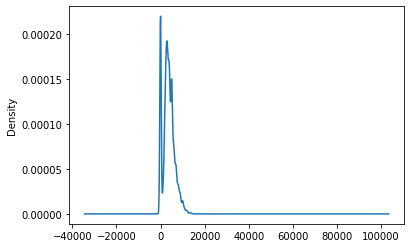

In [19]:
ntsb_1['rwy_len'].plot(kind='kde')

In [18]:
# binning values in 'rwy_len' column, wondering the best way to bin since we have values from 0- 69000, but most are between 0-20000

bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 100000]
labels =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
ntsb_1['rwy_len'] = pd.cut(ntsb_1['rwy_len'], bins,labels=labels)
col_metrics(ntsb_1, col='rwy_len')

Unique data:  [NaN, 3, 6, 4, 2, ..., 14, 15, 13, 21, 16]
Length: 18
Categories (21, int64): [1 < 2 < 3 < 4 ... 18 < 19 < 20 < 21]
Value counts:  3     7364
4     7106
5     5449
6     4126
2     2636
7     2430
8     1620
9     1125
10     596
1      412
11     364
12     183
13      55
14      54
15      10
16       1
21       1
17       0
18       0
19       0
20       0
Name: rwy_len, dtype: int64
Total nulls:  28173
Data type:  category


In [17]:
col_metrics(ntsb_1, col='rwy_width')

Unique data:  [      nan 4.000e+01 7.000e+01 1.000e+02 3.600e+01 7.500e+01 1.500e+02
 1.200e+02 5.000e+01 6.000e+01 3.000e+02 8.000e+01 1.530e+02 7.200e+01
 9.000e+01 3.000e+01 4.500e+01 3.500e+01 1.000e+01 2.000e+02 1.590e+02
 7.300e+01 1.750e+02 4.400e+01 6.500e+01 2.400e+01 2.500e+01 4.700e+01
 4.900e+01 6.600e+01 1.300e+02 4.800e+01 2.600e+01 1.100e+02 5.500e+01
 6.800e+01 1.600e+02 3.900e+01 4.200e+01 0.000e+00 4.300e+01 3.200e+01
 1.700e+02 2.500e+02 2.200e+01 1.250e+02 5.000e+02 8.500e+01 2.000e+01
 5.900e+01 7.700e+01 2.800e+01 1.800e+02 1.500e+01 2.090e+02 7.400e+01
 3.800e+01 1.150e+02 3.700e+01 1.400e+02 3.400e+01 1.010e+02 7.800e+01
 1.450e+02 6.200e+01 3.100e+01 2.100e+01 1.350e+02 6.100e+01 9.200e+01
 5.700e+01 1.800e+01 2.150e+02 7.100e+01 9.500e+01 1.140e+02 2.400e+02
 4.600e+01 2.100e+02 4.300e+02 1.130e+02 1.200e+01 3.300e+01 1.580e+02
 1.480e+02 2.300e+02 4.000e+02 9.600e+01 2.800e+02 9.800e+01 1.900e+02
 2.020e+02 2.700e+02 8.400e+01 2.600e+02 2.700e+01 5.100e+01 1.

In [19]:
ntsb_1['rwy_width'].round(0)

0           NaN
1          40.0
2          70.0
3         100.0
4           NaN
          ...  
104050     50.0
104062      NaN
104076      NaN
104079      NaN
104093      NaN
Name: rwy_width, Length: 61705, dtype: float64

In [23]:
ntsb_1['rwy_width'].max()

7201.0

<Axes: ylabel='Density'>

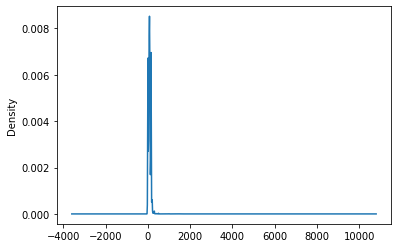

In [24]:
ntsb_1['rwy_width'].plot(kind='kde')

In [20]:
# binning values in 'rwy_width' column... same question as above

bins2 = [0,10,20,30,40,50,60,70,80,90,100,200,300,400,500,1000,8000]
labels2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

#bins2 = [0, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
#labels2 =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ntsb_1['rwy_width'] = pd.cut(ntsb_1['rwy_width'], bins2, labels=labels2)
col_metrics(ntsb_1, col='rwy_width')

Unique data:  [NaN, 4, 7, 10, 8, ..., 14, 2, 13, 16, 15]
Length: 17
Categories (16, int64): [1 < 2 < 3 < 4 ... 13 < 14 < 15 < 16]
Value counts:  11    8731
8     6862
10    6574
5     3598
6     2561
4     1405
3      951
7      650
2      287
12     268
9      212
14      37
13      26
1       22
16      21
15      13
Name: rwy_width, dtype: int64
Total nulls:  29487
Data type:  category


In [26]:
col_metrics(ntsb_1, col='eng_type')

Unique data:  ['rec' 'tp' 'tj' 'ts' 'unk' 'tf' nan 'none' 'elec' 'hr']
Value counts:  rec     55456
tp       2133
ts       2009
unk       763
tf        456
tj        273
none        7
elec        4
hr          1
Name: eng_type, dtype: int64
Total nulls:  603
Data type:  object


In [60]:
# Changing datatype for eng_type column to category
ntsb_1['eng_type'].astype('category')

0         rec
1         rec
2         rec
3          tp
4         rec
         ... 
104050    rec
104062    rec
104076    rec
104079    rec
104093     tp
Name: eng_type, Length: 61705, dtype: category
Categories (7, object): ['elec', 'hr', 'rec', 'tf', 'tj', 'tp', 'ts']

In [34]:
#replacing none and unk values from eng_type with nan
ntsb_1['eng_type'].mask(ntsb_1['eng_type'] == 'none', np.nan, inplace=True)
ntsb_1['eng_type'].mask(ntsb_1['eng_type'] == 'unk', np.nan, inplace=True)

In [25]:
ntsb_1['eng_mfgr'].unique()

array(['continental', 'lycoming', 'p&w', 'garrett', 'jacobs', 'allison',
       nan, 'rotax', 'turbomeca', 'warner', 'rolls-royce', 'walter',
       'franklin', 'wright', 'pzl-kalisz', 'hirth', 'volkswagen',
       'rotorway', 'subaru', 'pezetel', 'unknown', 'revmaster',
       'p&w canada', 'ford', 'bombardier', 'gansheimer', 'ge',
       'chevrolet', 'grob', 'china', 'mazda', 'fairchild', 'kinner',
       'bmw r-r', 'curtis wright', 'great plains', 'ama', 'hapi',
       'cameron', 'onan', 'hirtmotoren', 'milwaukee prt', 'avro',
       'allied signal', 'zenoah', 'packard', 'venture', 'jaguar',
       'pzl-rzeszow', 'vendeneyev', 'buick', 'h bouley(pma)',
       'williams intl', 'int harvester', 'arrow', 'mcculloch', 'cuyuna',
       'kfm', 'cfm', 'pzl mielec', 'lambert', 'nsi', 'kawasaki', 'amw',
       'voronezh', 'jpx', 'corvair', 'zhuzhou', 'wsk', 'shvetsov',
       'honda', 'housia', 'microal', 'monnett', 'limbach', 'mercury',
       'spencer', 'klimov', 'konig', 'mosler', 'orenda

In [24]:
ntsb_1.drop(columns=['hp_or_lbs', 'ntsb_no'])

,aircraft_ev_id,far_part,flight_plan_activated,damage,acft_make,acft_model,cert_max_gr_wt,num_eng,type_last_insp,date_last_insp,...,inj_tot_t,wx_cond_basic,Cause_Factor,crew_no,crew_category,crew_age,crew_sex,med_certf,pilot_flying,crew_inj_level
0,20001204x00000,135,NaN,subs,cessna,207,3800.0,1.0,100h,12/16/1998,...,1.0,vmc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,20001204x00004,135,NaN,subs,cessna,207,3800.0,1.0,aaip,12/14/1998,...,NaN,vmc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,20001204x00005,091,NaN,subs,piper,pa-22-160,1840.0,1.0,annl,3/14/1998,...,NaN,vmc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
3,20001204x00006,091,NaN,dest,beech,300,14100.0,2.0,aaip,1/14/1999,...,2.0,imc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
4,20001204x00007,091,NaN,dest,piper,pa-28-181,2550.0,1.0,unk,NaN,...,1.0,vmc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104050,20160721x55442,091,n,subs,rockwell international,114,3140.0,1.0,annl,25-may-16,...,3.0,vmc,NaN,1.0,plt,52.0,m,cl3,True,none
104062,20160721x74604,091,n,dest,piper,pa 30,2381.0,2.0,annl,22-sep-15,...,1.0,vmc,c,1.0,plt,58.0,m,cl3,True,fatl
104076,20160721x90029,137,n,subs,grumman acft eng cor-schweizer,g 164a,2500.0,1.0,100h,23-jun-16,...,1.0,vmc,c,1.0,plt,29.0,m,cl2,True,none
104079,20160722x63338,091,y,dest,vans,rv9,NaN,1.0,cond,16-jun-16,...,2.0,vmc,c,1.0,plt,80.0,m,cl3,True,fatl


In [33]:
#Cleaning names of engine manufacturers.

ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == '1/2 volkswagen', 'volkswagen', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aero engines (vw)', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == '4 burner type engines', '', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ã\x80/o', '', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'â\x82¬', '', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero engines (vw)', 'aero engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport', 'aero sport power', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aero sport power (lycoming)', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport power (lycoming)', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport power ltd', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero sport power ltd.', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aero-vee', 'aero vee', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aeromotors s.a.', 'aero motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerosport', 'aero sport power', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aerosport / lycoming', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerosport / lycoming', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerosport power', 'aero sport power', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aerovee', 'aero vee', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ai', 'airesearch', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aireasearch', 'airesearch', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'aireaserch/garrett', 'garrett', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'aireaserch/garrett', 'airesearch', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'airresearch', 'airesearch', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'airresearch/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'airresearch/honeywell', 'airesearch', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allied', 'allied signal', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allied/honeyw', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allied/honeyw', 'allied signal', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'alliedsignal', 'allied signal', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison (r/r)', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison (r/r)', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison / rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison / rolls royce', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison 250-c20b', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison c', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison engine', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison rolls royce', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison/rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison/rolls royce', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison/rolls-royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison/rolls-royce', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'allison/rr', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'allison/rr', 'allison', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'alllison', 'allison', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'ama (vw)', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ama/expr', 'ama', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'ama/expr lycoming)', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ama/expr lycoming', 'ama', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'arriel', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ariel', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'avco', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'avco lycoming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'barrett precision engines', 'barret precision engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'barrett performance engine', 'barret precision engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'bmw r-r', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bmw r-r', 'bmw', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'bmw rolls-royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bmw rolls-royce', 'bmw', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier rotex', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier-rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bombardier/rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'bristsidviper', 'Armstrong Siddeley', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'brp rotax gmbh7 co. kg', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cfm', 'cfm international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cfm intl', 'cfm international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cfm intl.', 'cfm international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chapallal', 'elroy air chaparral', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevrolet corvair', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevrolot', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevy', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'chevy geo metro', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'club crafters inc.', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'compact ra', 'compact radial engines, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'compact radial engines', 'compact radial engines, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'compact radial engines inc.', 'compact radial engines, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continental motor\'s inc', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'conintental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'conitnental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont motor', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'cont motor p. ponk', 'p.ponk', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont motor p. ponk', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont motor/perf eng', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont-motor', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cont. motor', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'contenental teledyne', 'teledyne turbine engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental teledyne', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenintal', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'continental teledyne motors', 'teledyne turbine engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continental teledyne motors', 'continental motors, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'continental/p. ponk', 'p.ponk', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continental/p. ponk', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continential', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continential motors', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continetal motors', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'continetnal', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contintental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contl', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'contnental', 'continental motors, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'corvair', 'chevrolet', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'covington', 'covington aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cub crafter', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cub crafters', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cubcrafters', 'club crafters, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtis - wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtis wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtis-wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtiss', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtiss wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'curtiswright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'custom', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'cuyana', 'cuyuna', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'dehav eng', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'dehavilland', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'detr. diesel', 'detroit diesel', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diamond', 'diamond aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech', 'diemech turbines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'diemech (walter)', 'walter aircraft engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech (walter)', 'diemech turbines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech turbine', 'diemech turbines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'diemech turbines inc', 'diemech turbines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eci', 'engine components, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eci titan', 'engine components, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eci/titan', 'engine components, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eggenfellner', 'eggenfellner aircraft, inc.', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'eggenfellner subaru', 'subaru', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'eggenfellner subaru', 'eggenfellner aircraft, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'elizalde, s.a.', 'elizalde', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'engine components internationa', 'engine components international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'engineair', 'engineair power systems', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'exp', 'experimental', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'experimental tcm', 'experimental', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'falconer', 'ryan falconer racing engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'falconer eng.', 'ryan falconer racing engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'frankin', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'franklin', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'franklyn', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'frnklin', 'franklin aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'g e', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garett', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garret airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garret airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garret/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garret/honeywell', 'garret', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett research', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett research', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett-airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett-airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett/airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett/airesearch', 'garret', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'garrett/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'garrett/honeywell', 'garret', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ge', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ge aviation czech', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gen.electric', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'general elect', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'general electrics', 'general electric', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'geo/metro', 'geo metro', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gipsy major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gm', 'general motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gm corvair', 'general motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'great plains', 'great plains aircraft supply company', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'great plains/volkswagen', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'great plains/volkswagen', 'great plains aircraft supply company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'great plans aircraft', 'great plains aircraft supply company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'greatplains', 'great plains aircraft supply company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'grob', 'grob aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsey major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsy major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gipsy major', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsy minor', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'gypsy moth', 'de havilland', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hacker a200', 'hacker', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'hapi vw', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hapi vw', 'hapi', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'heath avn', 'heath airplane company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirsh', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirth', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirthmotoren', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hirtmotoren', 'hirth engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hks', 'hks aviation engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hks aviation', 'hks aviation engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell - garrett', 'garret', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell - garrett', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell / airesearch', 'airesearch', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell / airesearch', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell garrett', 'garret', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell garrett', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell/garrett', 'garret', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell/garrett', 'honeywell aerospace', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'honeywell/lyc', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'honeywell/lyc', 'honeywell aerospace', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'housia', 'housai', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'hummel', 'hummel engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'huosai', 'housai', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'inntec', 'innovator technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'int harvester', 'solar aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ivchenco', 'ivchenko okb', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ivchenko', 'ivchenko okb', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jabaru', 'jabiru aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jabiru', 'jabiru aircraft', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jpx', 'jpx aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jpx aircraft engines', 'jpx aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'jpx-pul', 'jpx aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'kfm', 'italian american motor engineering', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'kinner', 'kinner airplane & motor corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'kinner co', 'kinner airplane & motor corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'le rhone', 'société des moteurs le rhôn', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lerhone', 'société des moteurs le rhôn', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'limbach', 'limbach', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'limbeck', 'limbach', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lom', 'lom praha', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ly-con', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lyc', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lyco/wright', 'curtiss-wright', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lyco/wright', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoiming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycom', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomimg', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomin', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lycoming (curtis-wright)', 'curtiss-wright', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming (curtis-wright)', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming (modified)', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming engines', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming o-360-a1a', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lycoming-bmw', 'bmw', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming-bmw', 'lycoming', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'lycoming/honeywell', 'honeywell aerospace', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycoming/honeywell', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycomong', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'lycon', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mattittuck', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mattituck', 'teledyne turbine engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'mazda/atkins', 'atkins', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mazda/atkins', 'mazda', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mcculloch', 'mcculloch aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mccullock', 'mcculloch aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mccullough', 'mcculloch aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mid-west', 'jet midwest, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mid-west engines', 'jet midwest, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'morris motors', 'morris engines limited', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'motori zanzoterra', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'mz', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'national flight service', 'national flight services, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'national flight service', 'national flight services, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'national flight services inc', 'national flight services, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'none', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'northrop corp', 'northrop corporation ', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'nsi', 'nsi propulsion systems, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'nsi aero', 'nsi propulsion systems, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'o-360-a4k', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'o-470l', 'teledyne continental motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p & w', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p & w', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p & w canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p. ponk', 'p.ponk', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p/w canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p&w', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p&w canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'p&wc', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'packard', 'packard motors', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'packard r.r.', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'packard r.r.', 'packard motors', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'packard rolls royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'packard rolls royce', 'packard motors', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'patt &whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pbs', 'pbs aerospace', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'penn yann aero', 'penn yan aero', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'penn-yan', 'penn yan aero', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pezatel', 'pezetel', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'pkrd-roll', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pkrd-roll', 'packard motors', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'pkrd-roll royce', 'rolls-royce', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pkrd-roll royce', 'pkrd-roll royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'polaris', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'prat and whitney aircraft', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney - canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney aircraft of ca', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney of canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & whitney-canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'prat and whitney aircraft', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt & witney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt &whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitnety canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney - canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt and whitney of canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt-whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt/whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt& whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt&whitney', 'pratt & whitney', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pratt&whitney-canada', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pw&c', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pwc', 'pratt & whitney canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl mielec', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl wsk', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-kalisz', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-okecie', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-rzeszow', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'pzl-warszana', 'pzl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ram', 'ram racing engines, ltd.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ram racing engines ltd', 'ram racing engines, ltd.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rev.', 'revmaster aviation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'revmaster', 'revmaster aviation', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rogers-lycoming', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rogers-lycoming', 'rogers', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce (allison)', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce (allison)', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce / allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce / allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce-allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce-allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce/ allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce/ allison', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls royce/allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls royce/allison', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royc', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls-royce allison', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce allison', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce corporation', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce deutschland', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls-royce turbomeca', 'safran helicopter engines', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce turbomeca', 'rolls-royce', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'rolls-royce(allison)', 'allison', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rolls-royce(allison)', 'rolls-royce', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotax', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotax gmbh', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotax gmbh & co.', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotec', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotex', 'brp-rotax', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotortway', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotorway', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rotorway international', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'rw', 'rotorway international, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ryan', 'ryan falconer racing engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'safran (formerly turbomeca)', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'shvetsoc', 'shvetsov', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'solair', 'solair group, llc', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'subaru - stratus built', 'stratus 2000, inc.', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'subaru - stratus built', 'subaru', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'subaru/eggenfellner', 'eggenfellner aircraft, llc', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'subaru/eggenfellner', 'subaru', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'subuaru', 'subaru', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'suburu', 'subaru', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'superior', 'superior air parts, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'superior air parts', 'superior air parts, inc.', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledine continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledye continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyn continental', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyn continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne cont', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental mortors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental motor', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne matituck', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne mattituck', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne-continental', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne-continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'teledyne/cont', 'teledyne turbine engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'textron lyc.', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'textron lyc.', 'textron aviation', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'textron lycoming', 'lycoming', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'textron lycoming', 'lycoming', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'titan', 'continental aerospace technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tmx', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tomanski', 'tumanski', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'toyota/auto', 'toyota', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tubomecca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbo meca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tubomecca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbomeca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbomeca usa', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'turbomecca', 'safran helicopter engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'two stroke international', '2si', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'tyledyne continental motors', 'teledyne turbine engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'u/a of canada', 'u/a canada', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ul', 'ulpower aero engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'ul power', 'ulpower aero engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unk', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unk/nr', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unkn', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'unknown', np.nan, inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'v.w.', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeheyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeneev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedenev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeneyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedeneyez', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vedenyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vellie', 'velie', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vendeneyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vendenyev', 'vedeneyev', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'viking', 'viking aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'viking aircraft engines', 'viking aircraft engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'viking conversion of honda', 'honda', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'viking conversion of honda', 'viking aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagan', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagoen', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagon', 'volkswagen', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'volkswagon/great plains', 'great plains aircraft supply company', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'volkswagon/great plains', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vw', 'volkswagen', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'vw- hummel', 'hummel', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'vw- hummel', 'volkswagen', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walter', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walter engine incorporated', 'walter aircraft engines', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'walter/ge', 'general electric', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walter/ge', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'walther', 'walter aircraft engines', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'warner', 'warner aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'warner aircraft engines', 'warner aircraft corporation', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'warner super scarab', 'warner aircraft corporation', inplace=True)
ntsb_1['secondary_eng_mfgr'] = np.where(ntsb_1['eng_mfgr'] == 'watson "vw"', 'volkswagen', '')
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'watson "vw"', 'watson', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'williams', 'williams international', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'williams', 'williams international company', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'williams', 'williams intl', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wright', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wright cyclone', 'curtiss-wright', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk pzl kalis', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk pzl kalisz', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk-pzl', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wsk-pzl-k', 'pzl wsk-kalisz', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'wynn corvair', 'wynn', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'xtreem 360', 'xtremeair gmbh', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'zanzarterra', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'zanzottera', 'zanzottera technologies', inplace=True)
ntsb_1['eng_mfgr'].mask(ntsb_1['eng_mfgr'] == 'zeonoa', 'zenoah', inplace=True)

Plans for columns: <br>
'rwy_num': Not sure... should we leave this? Or maybe join airport and runway number? <br>
'rwy_len': bucketize lengths<br>
'rwy_width': format number (currently scientific), then bucketize widths<br>
'ifr_equipped_cert': Good as is.<br>
'eng_no': Remove 448 nulls?<br>
'eng_type': Not sure what this is referring to.. need to spell these out when I figure it out... thinking 'elec' is electric.. <br>
'eng_mfgr': Consolidate engine manufacturers (i.e. gm and general motors)<br>
'hp_or_lbs': Change dtype from int64 to string, also, is this needed?<br>
'carb_fuel_injection': Change dtype from int64 to string <br>
'eng_time_total': bucketize hours<br>
'eng_time_last_insp': format number (currently scientific), then bucketize<br>
'ntsb_no': remove<br>
'ev_type': Change dtype from int64 to string <br>
'ev_date': convert dtype to datetime (date mm/dd/yyy)<br>
'ev_dow': Change dtype from int64 to string, make sure these are ordered categories<br>
'ev_time': format time dtype, take a look at bucketizing by hour<br>
'ev_city':  Change dtype from int64 to string <br>
'ev_state':  Change dtype from int64 to string, ensure all reflect a US state<br>
'ev_year': Remove? Unless an airport is more risky during different time periods which might be possible<br>
'ev_month': Ensure ordered list reflecting months <br>
'latitude': convert dtype to VARCHAR or DOUBLE. also maybe.... "You can use clustering algorithm like k-Nearest Neighbor algorithm to group your geo-location data (using a small number of potential clusters) and assign each cluster or a group a unique id. These unique id can then replace your latitude and longitude column."<br>
'longitude': see lat<br>
'apt_name': compare against airport list, consolidate private and private airstrip, and private strip


In [58]:
ntsb_1['carb_fuel_injection'].astype('category')

0         finj
1         finj
2         carb
3          NaN
4         carb
          ... 
104050    finj
104062    finj
104076    carb
104079    finj
104093     NaN
Name: carb_fuel_injection, Length: 61705, dtype: category
Categories (2, object): ['carb', 'finj']

In [57]:
ntsb_1['carb_fuel_injection'].astype('category')

0         finj
1         finj
2         carb
3          NaN
4         carb
          ... 
104050    finj
104062    finj
104076    carb
104079    finj
104093     NaN
Name: carb_fuel_injection, Length: 61705, dtype: category
Categories (2, object): ['carb', 'finj']

In [56]:
ntsb_1['ev_type'].astype('category')

0         acc
1         acc
2         acc
3         acc
4         acc
         ... 
104050    acc
104062    acc
104076    acc
104079    acc
104093    acc
Name: ev_type, Length: 61705, dtype: category
Categories (2, object): ['acc', 'inc']

In [45]:
ntsb_1['ev_city'].astype('string')

0           quinhagak
1              chevak
2           anchorage
3             cullman
4             brevard
             ...     
104050         munday
104062     plainfield
104076         topeka
104079    springfield
104093         zamora
Name: ev_city, Length: 61705, dtype: string

In [46]:
ntsb_1['ev_state'].astype('string')

0         ak
1         ak
2         ak
3         al
4         nc
          ..
104050    tx
104062    il
104076    ks
104079    oh
104093    ca
Name: ev_state, Length: 61705, dtype: string

In [49]:
ntsb_1['eng_time_total'].unique()



array([  nan,    0., 2830., ...,  179., 3696.,   68.])

In [52]:

ntsb_1['eng_time_total'].unique()
ntsb_1['eng_time_total'].max()

bins3 = [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000]
labels3 = [1,2,3,4,5,6,7,8,9,10]

ntsb_1['eng_time_total'] = pd.cut(ntsb_1['eng_time_total'], bins3, labels=labels3)
col_metrics(ntsb_1, col='eng_time_total')

Unique data:  [NaN, 1, 2, 3, 9, 10, 4, 6, 7, 5]
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]
Value counts:  1     2180
2      340
3       91
4       18
6        6
5        4
10       2
7        1
9        1
8        0
Name: eng_time_total, dtype: int64
Total nulls:  59062
Data type:  category


In [54]:
ntsb_1['eng_time_last_insp'].round()
ntsb_1['eng_time_last_insp'].max()
bins4 = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000, 11000, 12000, 13000]
labels4 = [1,2,3,4,5,6,7,8,9,10,11,12,13]

ntsb_1['eng_time_last_insp'] = pd.cut(ntsb_1['eng_time_last_insp'], bins4, labels=labels4)
col_metrics(ntsb_1, col='eng_time_last_insp')

Unique data:  [NaN, 1, 2, 7, 3, 6, 13, 5, 4]
Categories (13, int64): [1 < 2 < 3 < 4 ... 10 < 11 < 12 < 13]
Value counts:  1     2123
2       23
3        8
4        3
5        3
7        2
6        1
13       1
8        0
9        0
10       0
11       0
12       0
Name: eng_time_last_insp, dtype: int64
Total nulls:  59541
Data type:  category


In [ ]:
# Pending Cleaning

'eng_no': Remove 448 nulls?
'ev_time': format time dtype, take a look at bucketizing by hour
'ev_year': Remove? Unless an airport is more risky during different time periods which might be possible
'latitude': convert dtype to VARCHAR or DOUBLE. also maybe.... "You can use clustering algorithm like k-Nearest Neighbor algorithm to group your geo-location data (using a small number of potential clusters) and assign each cluster or a group a unique id. These unique id can then replace your latitude and longitude column."
'longitude': see lat
'apt_name': compare against airport list, consolidate private and private airstrip, and private strip


In [55]:
ntsb_1['ev_dow'].astype('category')

0         su
1         tu
2         we
3         th
4         we
          ..
104050    mo
104062    th
104076    th
104079    fr
104093    sa
Name: ev_dow, Length: 61705, dtype: category
Categories (7, object): ['fr', 'mo', 'sa', 'su', 'th', 'tu', 'we']

In [59]:
ntsb_1['ev_month'].astype('category')

0         1
1         1
2         1
3         1
4         1
         ..
104050    6
104062    7
104076    7
104079    7
104093    7
Name: ev_month, Length: 61705, dtype: category
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]

In [ ]:
# the columns to be used to create the labels are: inj_tot_t, damage, crew_inj_level, ev_highest_injury, damage

## ERICK'S SECITON

### CHI'S SECTION